In [35]:
# design a sinc RF pulse and simulate it
using Plots
#plotly()
#using PlotlyJS
#plotly()
using ForwardDiff
#using MAT
using Optim
#using Statistics
using DelimitedFiles

# to get multiple threads, launch IJulia notebook using:
# ENV["JULIA_NUM_THREADS"] = 4; using IJulia; notebook(detached=true)
print(Threads.nthreads())
gr()

12

Plots.GRBackend()

# Define Sequence, RF, and Tissue Parameters

In [2]:
 # SE Sequence parameters - the pre-simulation will use these to determine the target EX flip
#T1 = 800 # 3T 
T1 = 1750 # 7T
TR = 300 
TE = 57
Mz0 = 1
nTRs = 25
nIso = 1

# RF Pulse parameters - these apply to all three pulses 
N = 128
tb = 8
d1 = 0.01
d2 = 0.01
os = 8 # target pattern oversampling factor

8

# Step 1: For this pulse sequence and tissue type, work out the target excitation flip angles and steady-state $M_{xyz}$'s at TE (neglecting transverse decay)

# SE Sequence

147
0.3596482174770758
-0.2411157864647374


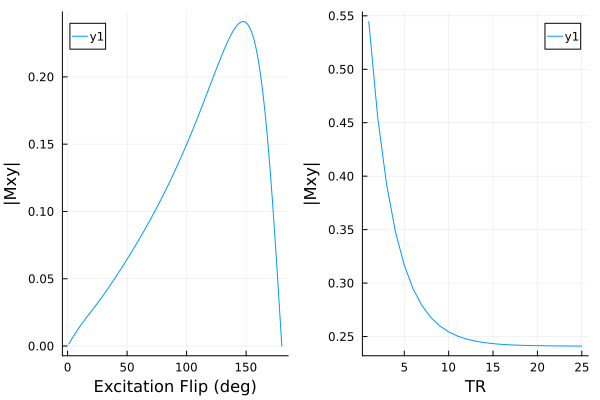

In [33]:
# spin echo 
# simulate to determine the best EX flip angle
exFlip = 1 : 180 # degrees; EX flip angles to test
refFlip = 180 # degrees; refocusing flip angle

phs = exp.(im * 2 * π / nIso * (0 : nIso - 1))
Mxyss = zeros(length(exFlip), nTRs)
Mzss = zeros(length(exFlip), nTRs)
for ii = 1 : length(exFlip)
    Mz = Mz0 #* ones(nIso)
    for kk = 1 : nTRs
        
        # apply 90 - RF along y
        Mxy = Mz * -sind(exFlip[ii]) + im * 0
        # Record Mxy immediately after EX
        Mz *= cosd(exFlip[ii])
        
        # relax to to TE / 2
        Mz = Mz * exp(-TE / 2 / T1) + Mz0 * (1 - exp(-TE / 2 / T1))
        
        # apply crushed 180 - RF along x
        Mxyt = real(Mxy) + im * (imag(Mxy) * cosd(refFlip))
        Mz = Mz * cosd(refFlip)
                
        # relax to TE
        Mz = Mz * exp(-TE / 2 / T1) + Mz0 * (1 - exp(-TE / 2 / T1))
        
        # record Mxyz at TE
        Mxyss[ii, kk] = Mxy
        Mzss[ii, kk] = Mz
        
        # relax to TR; can neglect Mxy now since we assume its spoiled before next TR
        Mz = Mz * exp(-(TR - TE) / T1) + Mz0 * (1 - exp(-(TR - TE) / T1))
        
    end
end

# plot simulation results - 
# peak Mxy versus ex flip angle, and signal versus TRs to see when it hits steady state
ind = argmax(abs.(Mxyss[:, end]))
bestFlipSE = exFlip[ind]
println(bestFlipSE)
bestMzSE = Mzss[ind,end]
println(bestMzSE)
bestMxySE = Mxyss[ind, end]
println(bestMxySE)

p1 = plot(exFlip, abs.(Mxyss[:, end]), xlabel="Excitation Flip (deg)", ylabel="|Mxy|")
p2 = plot(1 : nTRs, abs.(Mxyss[bestFlipSE, :]), xlabel="TR", ylabel="|Mxy|")
#[p1, p2]
plot(p1, p2)

# GRE Sequence

33
0.46794611348862863
-0.2924483978601171


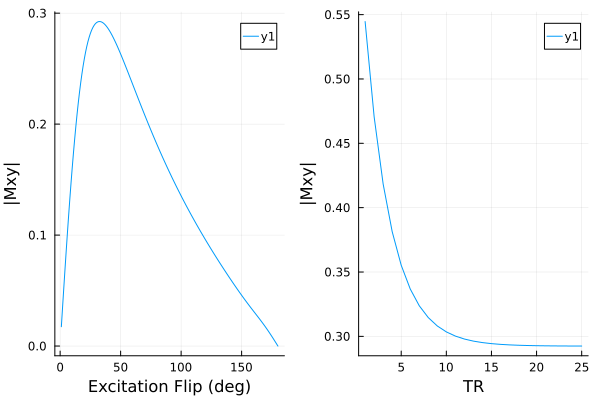

In [32]:
# Gradient echo 
# simulate to determine the best EX flip angle
exFlip = 1 : 180 # degrees; EX flip angles to test

Mxyss = zeros(length(exFlip), nTRs)
Mzss = zeros(length(exFlip), nTRs)
for ii = 1 : length(exFlip)
    Mz = Mz0 #* ones(nIso)
    for kk = 1 : nTRs
        
        # apply 90 - RF along y
        Mxy = Mz * -sind(exFlip[ii]) + im * 0
        # Record Mxy immediately after EX
        Mz *= cosd(exFlip[ii])
        
        # relax to to TE
        Mz = Mz * exp(-TE / T1) + Mz0 * (1 - exp(-TE / T1))        
        
        # record Mxyz at TE
        Mxyss[ii, kk] = Mxy
        Mzss[ii, kk] = Mz
        
        # relax to TR; can neglect Mxy now since we assume its spoiled before next TR
        Mz = Mz * exp(-(TR - TE) / T1) + Mz0 * (1 - exp(-(TR - TE) / T1))
        
    end
end

# plot simulation results - 
# peak Mxy versus ex flip angle, and signal versus TRs to see when it hits steady state
ind = argmax(abs.(Mxyss[:, end]))
bestFlipGRE = exFlip[ind]
println(bestFlipGRE)
bestMzGRE = Mzss[ind,end]
println(bestMzGRE)
bestMxyGRE = Mxyss[ind, end]
println(bestMxyGRE)

p1 = plot(exFlip, abs.(Mxyss[:, end]), xlabel="Excitation Flip (deg)", ylabel="|Mxy|")
p2 = plot(1 : nTRs, abs.(Mxyss[bestFlipGRE, :]), xlabel="TR", ylabel="|Mxy|")

plot(p1, p2)

# Step 2: Define the Target Patterns and Error Weights, and the Simulation and Error Functions

In [5]:
# now let's set up our own target patterns
function dinf(d1, d2)

    a1 = 5.309e-3
    a2 = 7.114e-2
    a3 = -4.761e-1
    a4 = -2.66e-3
    a5 = -5.941e-1
    a6 = -4.278e-1

    l10d1 = log10(d1)
    l10d2 = log10(d2)

    d = (a1 * l10d1^2 + a2 * l10d1 + a3) * l10d2 + (a4 * l10d1^2 + a5 * l10d1 + a6)
    
    return d
    
end

dinf (generic function with 1 method)

In [6]:
#calculate fractional transition width (ftw) using dinf(an emprical function for ripple filters)
ftw =  dinf(d1, d2) / tb
# set up target pattern
Npad = 0 #N ÷ 4 # number of additional time points to add on the ends of second pulse
f = [0, (1 - ftw) * (tb / 2), (1 + ftw) * (tb / 2), (N / 2)] / (N / 2) 
x = (-N / 2 : 1 / os : N / 2 - 1 / os)

-64.0:0.125:63.875

# Step 3: Set up Refocusing target pattern and error weighting

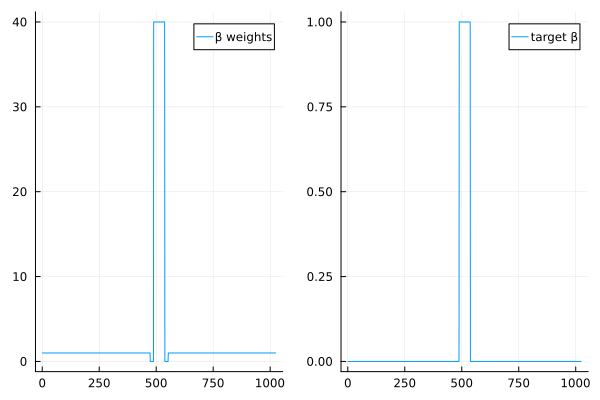

In [7]:
βd = zeros(N * os)
βd[abs.(collect(x) ./ (N / 2)) .< f[2]] .= 1

# error weights for filter design w (for filter) 
# the weights are zero in the transition region between pass and stopband 
βw = zeros(N * os, 1)
βw[abs.(collect(x) ./ (N / 2)) .> f[3]] .= 1.0
βw[abs.(collect(x) ./ (N / 2)) .< f[2]] .= sqrt(d2) / (d1 / 4)

p3 = plot(βw, label="β weights")
p4 = plot(βd, label="target β")
plot(p3, p4)

# Step 4: Set up excitation target pattern and error weighting

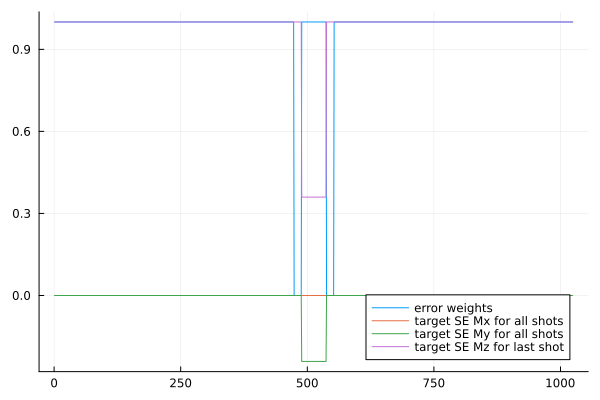

In [8]:
# Target Mxy after excitation pulse, times expected steady state Mz
MydSE = zeros(N * os) 
MydSE[abs.(collect(x) ./ (N / 2)) .< f[2]] .= bestMxySE
MxdSE = zeros(N * os) 

# target Mz after excitation pulse, times expected steady state Mz
MzdSE = ones(N * os)
MzdSE[abs.(collect(x) ./ (N / 2)) .< f[2]] .= bestMzSE

w = zeros(N * os, 1)
w[abs.(collect(x) ./ (N / 2)) .< f[2]] .= 1.0
w[abs.(collect(x) ./ (N / 2)) .> f[3]] .= 1.0

plot(w, label = "error weights")
plot!(MxdSE, label = "target SE Mx for all shots")
plot!(MydSE, label = "target SE My for all shots")
plot!(MzdSE, label = "target SE Mz for last shot")

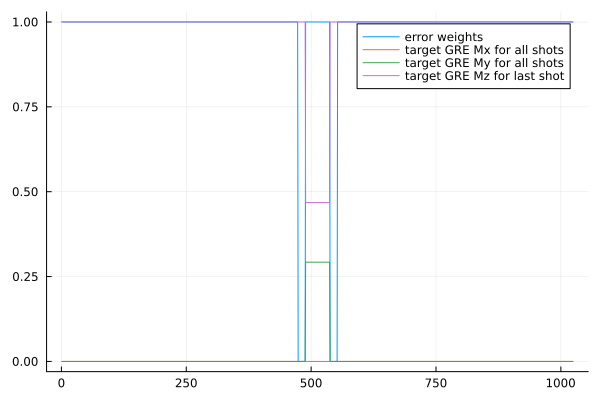

In [9]:
# Target Mxy at TE, GRE sequence 
MydGRE = zeros(N * os) 
MydGRE[abs.(collect(x) ./ (N / 2)) .< f[2]] .= -real(bestMxyGRE)
MxdGRE = zeros(N * os) 

# target Mz after excitation pulse, times expected steady state Mz
MzdGRE = ones(N * os)
MzdGRE[abs.(collect(x) ./ (N / 2)) .< f[2]] .= bestMzGRE

# error weighting already defined by SE 
#w = zeros(N * os, 1)
#w[abs.(collect(x) ./ (N / 2)) .< f[2]] .= 1.0
#w[abs.(collect(x) ./ (N / 2)) .> f[3]] .= 1.0

plot(w, label = "error weights")
plot!(MxdGRE, label = "target GRE Mx for all shots")
plot!(MydGRE, label = "target GRE My for all shots")
plot!(MzdGRE, label = "target GRE Mz for last shot")

In [10]:
# To simulate pulses time-point-by-time-point - differentiable 

function BlochSim_spinor(ϕ, gϕ)
    
    α = 1
    β = 0
    
    N = length(ϕ)
    
    z = exp(-im * gϕ)    
    for ii = 1 : N
       
        # Apply RF rotation
        a = cos(ϕ[ii] / 2)
        b = im * sin(ϕ[ii] / 2)
        
        αt = a * α - conj(b) * β
        βt = b * α + a * β
        
        α = αt
        β = βt
        
        # Apply Gradient rotation
        β *= z 
        
    end
    
    α *= exp(im * gϕ * N / 2)
    β *= exp(im * gϕ * N / 2)
    
    return α, β
    
end

BlochSim_spinor (generic function with 1 method)

# Function to simulate the steady state SE signal for an RF EX + SE pair

In [11]:
function SESeqSim(gα, rfex, rfref, T1, TE, TR, nTRs)

    Mx = 0
    My = 0
    Mz = 1
    # simulate nTRs to get steady state Mxy
    α, β = BlochSim_spinor(rfex, gα)
    _, βref = BlochSim_spinor(rfref, gα)
    for jj = 1 : nTRs
        
        # simulate the EX pulse
        Mxy = Mz * 2 * conj(α) * β * exp(im * gα * length(rfex) / 2)
        Mx = real(Mxy)
        My = imag(Mxy)
        Mz *= 1 - 2 * abs(β)^2 # Pauly parameters Eqtn 23

        # relax Mz to TE / 2
        Mz = Mz * exp(-TE / 2 / T1) + 1 * (1 - exp(-TE / 2 / T1))

        # apply crushed 180 - RF along x
        Mz *= 1 - 2 * abs(βref)^2 # Pauly parameters Eqtn 23

        Mxy = -(Mx - im * My) * βref^2
        Mx = real(Mxy)
        My = imag(Mxy) 

        # relax to TE
        Mz = Mz * exp(-TE / 2 / T1) + 1 * (1 - exp(-TE / 2 / T1))

        if jj < nTRs
            # relax Mz to end of TR
            Mz = Mz * exp(-(TR - TE) / T1) + 1 * (1 - exp(-(TR - TE) / T1))
        end
        
    end     
    
    return Mx, My, Mz, βref 

end

SESeqSim (generic function with 1 method)

# Function to simulate the steady state GRE signal for an RF EX pulse

In [12]:
function GRESeqSim(gα, rfgre, T1, TE, TR, nTRs)

    Mx = 0
    My = 0
    Mz = 1
    # simulate nTRs to get steady state Mxy
    α, β = BlochSim_spinor(rfgre, gα)
    for jj = 1 : nTRs
        
        # simulate the EX pulse
        Mxy = Mz * 2 * conj(α) * β * exp(im * gα * length(rfgre) / 2)
        Mx = real(Mxy)
        My = imag(Mxy)
        Mz *= 1 - 2 * abs(β)^2 # Pauly parameters Eqtn 23

        # relax to TE
        Mz = Mz * exp(-TE / T1) + 1 * (1 - exp(-TE / T1))

        if jj < nTRs
            # relax Mz to end of TR
            Mz = Mz * exp(-(TR - TE) / T1) + 1 * (1 - exp(-(TR - TE) / T1))
        end
        
    end    

    return Mx, My, Mz 

end

GRESeqSim (generic function with 1 method)

# Function to Calculate the Errors Between Target Patterns and Between SE and GRE Profiles

In [13]:
# define a BlochSim we can use to calculate error - should encapsulate myBlochSim here
function BlochSimErrGRESE(rf, x, MxdSE, MydSE, MzdSE, MxdGRE, MydGRE, MzdGRE, nTRs, w, T1, TE, TR, βw, βd, λ, grenorm, senorm)
               
    rfex = rf[1:length(rf)÷3]
    rfref = rf[length(rf)÷3+1:2*length(rf)÷3]
    rfgre = rf[2*length(rf)÷3+1:end]

    N = length(MxdSE)

    err = 0 
    
    for ii = 1 : N # loop over spatial locations
        
        # gradient rotation for this spatial location
        gα = 2 * π * x[ii] / (N / 8)  

        # Spin echo sequence simulation
        MxSE, MySE, MzSE, βref = SESeqSim(gα, rfex, rfref, T1, TE, TR, nTRs)

        # add error of last Mxyz
        err += w[ii] * ((MxSE - MxdSE[ii])^2 + (MySE - MydSE[ii])^2 + (MzSE - MzdSE[ii])^2) / sum(w)

        # add refocusing error
        err += βw[ii] * abs(βref - im * βd[ii])^2 / sum(βw)

        # GRE sequence simulation
        MxGRE, MyGRE, MzGRE = GRESeqSim(gα, rfgre, T1, TE, TR, nTRs)

        # add error of last Mxyz
        err += w[ii] * ((MxGRE - MxdGRE[ii])^2 + (MyGRE - MydGRE[ii])^2 + (MzGRE - MzdGRE[ii])^2) / sum(w)

        # add likeness error - GRE and SE are complex conjugated wrt each other so we add Mx instead of subtract 
        err += λ * ((MySE / senorm - MyGRE / grenorm)^2 + (MxSE / senorm + MxGRE / grenorm)^2)
        
    end
    
    #err += 0.001 * sum(abs.(rf).^2)
    
    return err
    
end

BlochSimErrGRESE (generic function with 1 method)

# Run the Optimization

In [22]:
#λ = 0.01 # tb 4 and 6 
λ = 0.001 # tb 8 
grenorm = -real(bestMxyGRE)
senorm = bestMxySE
errHandleGRESE = rf -> BlochSimErrGRESE(rf, x, MxdSE, MydSE, MzdSE, MxdGRE, MydGRE, MzdGRE, nTRs, w, T1, TE, TR, βw, βd, λ, grenorm, senorm)

# Use Optim.jl to do a BFGS optimization of 'errHandle(rf)' using autodiff for gradients
rfoc = 0.001 .+ zeros(3 * (N))
res = optimize(errHandleGRESE, rfoc, method = ConjugateGradient(); 
    autodiff = :forward, show_trace = :true, show_every = :20, 
    iterations = :2000, g_tol = :1e-5)

Iter     Function value   Gradient norm 
     0     7.010334e-01     6.738818e-01
 * time: 8.392333984375e-5


    20     1.930759e-02     1.370346e-02
 * time: 37.743196964263916


    40     4.637930e-03     7.985052e-03
 * time: 69.2168960571289


    60     1.117097e-03     4.890128e-03
 * time: 100.71638894081116


    80     3.889572e-04     1.935392e-03
 * time: 132.6113519668579


   100     2.662963e-04     9.173564e-04
 * time: 164.9817509651184


   120     2.242319e-04     3.858679e-04
 * time: 196.94094586372375


   140     2.136201e-04     4.143281e-04
 * time: 228.5657250881195


   160     2.058847e-04     4.844567e-04
 * time: 260.3212380409241


   180     1.999534e-04     2.448035e-04
 * time: 292.7408928871155


   200     1.977433e-04     1.801594e-04
 * time: 324.444580078125


   220     1.971645e-04     7.948665e-05
 * time: 356.00136709213257


   240     1.970351e-04     4.182171e-05
 * time: 387.5492260456085


   260     1.969455e-04     6.701907e-05
 * time: 419.37881207466125


   280     1.968903e-04     2.382690e-05
 * time: 451.9885470867157


   300     1.968698e-04     1.400193e-05
 * time: 484.3894898891449


   320     1.968579e-04     1.322940e-05
 * time: 516.5554349422455


 * Status: success

 * Candidate solution
    Final objective value:     1.968540e-04

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.42e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.24e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.57e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.31e-06 ≰ 0.0e+00
    |g(x)|                 = 9.02e-06 ≤ 1.0e-05

 * Work counters
    Seconds run:   530  (vs limit Inf)
    Iterations:    328
    f(x) calls:    661
    ∇f(x) calls:   333


# Extract the Pulses

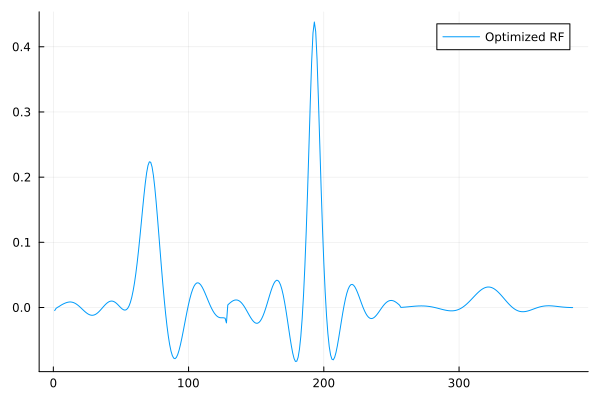

In [23]:
rfoc = Optim.minimizer(res)
plot(rfoc, label = "Optimized RF")

# Simulate the Final Pulses and Display

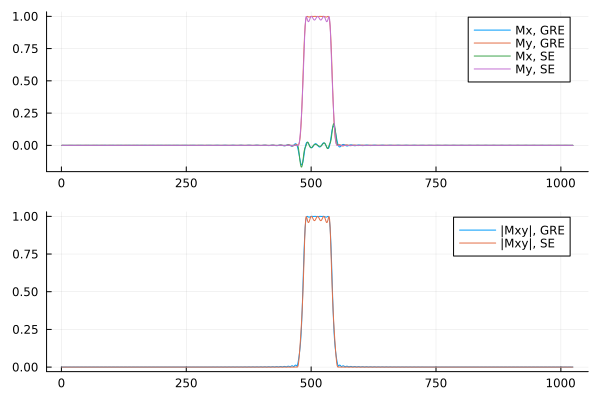

In [49]:
rfex = rfoc[1:N]
rfref = rfoc[N+1:2*N]
rfgre = rfoc[2*N+1:end]

MxSE = zeros(N * os)
MySE = zeros(N * os)
MxGRE = zeros(N * os)
MyGRE = zeros(N * os)

for ii = 1 : N * os # loop over spatial locations
        
    # gradient rotation for this spatial location
    gα = 2 * π * x[ii] / N
    
    # Spin echo sequence simulation
    MxSE[ii], MySE[ii], _, _ = SESeqSim(gα, rfex, rfref, T1, TE, TR, nTRs)    

    # GRE sequence simulation
    MxGRE[ii], MyGRE[ii], _ = GRESeqSim(gα, rfgre, T1, TE, TR, nTRs)
    
end

p1 = plot(-MxGRE / grenorm, label = "Mx, GRE")
plot!(p1, MyGRE / grenorm, label = "My, GRE")
plot!(p1, MxSE / senorm, label = "Mx, SE")
plot!(p1, MySE / senorm, label = "My, SE")

p2 = plot(abs.(MxGRE + im .* MyGRE) ./ grenorm, label = "|Mxy|, GRE")
plot!(p2, abs.(MxSE + im .* MySE) ./ -senorm, label = "|Mxy|, SE")

plot(p1, p2, layout=(2,1))

#print(abs(sum(MxGRE + im .* MyGRE) ./ grenorm))
#print(abs(sum(MxSE + im .* MySE) ./ -senorm))


# Separately Simulate the Different Pulses, to Better Understand the Profiles

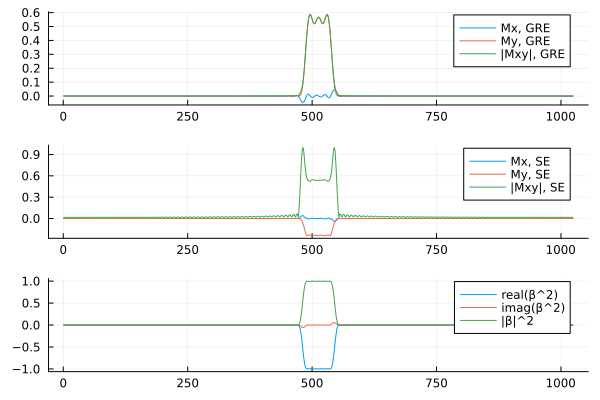

In [31]:
rfex = rfoc[1:N]
rfref = rfoc[N+1:2*N]
rfgre = rfoc[2*N+1:end]

MxSEEX = zeros(N * os)
MySEEX = zeros(N * os)
MxGREEX = zeros(N * os)
MyGREEX = zeros(N * os)
βref = zeros(N * os) .+ im * 0

for ii = 1 : N * os # loop over spatial locations
        
    # gradient rotation for this spatial location
    gα = 2 * π * x[ii] / N
    
    # Spin Echo EX
    α, β = BlochSim_spinor(rfex, gα)
    # Mxy assuming equilibrium Mz 
    Mxy = 2 * conj(α) * β * exp(im * gα * length(rfex) / 2)
    MxSEEX[ii] = real(Mxy)
    MySEEX[ii] = imag(Mxy)

    # Spin Echo REF
    _, βref[ii] = BlochSim_spinor(rfref, gα)

    # GRE EX 
    α, β = BlochSim_spinor(rfgre, gα)
    # Mxy assuming equilibrium Mz 
    Mxy = 2 * conj(α) * β * exp(im * gα * length(rfgre) / 2)
    MxGREEX[ii] = real(Mxy)
    MyGREEX[ii] = imag(Mxy)
    
end

p1 = plot(-MxGREEX, label = "Mx, GRE")
plot!(p1, MyGREEX, label = "My, GRE")
plot!(p1, abs.(MxGREEX .+ im .* MyGREEX), label = "|Mxy|, GRE")

p2 = plot(MxSE, label = "Mx, SE")
plot!(p2, MySE, label = "My, SE")
plot!(p2, abs.(MxSEEX .+ im .* MySEEX), label = "|Mxy|, SE")

p3 = plot(real.(βref.^2), label = "real(β^2)")
plot!(p3, imag.(βref.^2), label = "imag(β^2)")
plot!(p3, abs.(βref.^2), label = "|β|^2")

plot(p1, p2, p3, layout=(3,1))


# Write the Waveforms to Text Files

In [37]:
# unnormalized - units of radians 
open("rfex_se.txt", "w") do io
    writedlm(io, rfex)
end
open("rfref_se.txt", "w") do io
    writedlm(io, rfref)
end
open("rfex_gre.txt", "w") do io
    writedlm(io, rfgre)
end

# each pulse normalized to max of 1
open("rfex_se_norm.txt", "w") do io
    writedlm(io, rfex ./ maximum(abs.(rfex)))
end
open("rfref_se_norm.txt", "w") do io
    writedlm(io, rfref ./ maximum(abs.(rfref)))
end
open("rfex_gre_norm.txt", "w") do io
    writedlm(io, rfgre ./ maximum(abs.(rfgre)))
end

# Observations/Opportunities for Improvement

1. For high TB, the SE signal profile ripples increase. From looking at the independent excitation profiles, it appears that most of the ripple is in the SE excitation pulse profile. We could perhaps increase the number of points in that pulse and maybe also the REF pulse to reduce that rippling, without changing the target patterns. Alternatively/in addition, could reduce stop band weighting of the EX pulse's error, since those ripples are squashed by the REF pulse, though that would increase crosstalk between slices.
2. The EX pulse produces some ripples outside the slice that are higher than the SE ripples; could up-weight the stopband for that pulse, and/or again add more time points to the pulse without changing target pattern. 